In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

from torch.utils.tensorboard import SummaryWriter

csv_file = 'fer2013.csv'
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [2]:
resnet34 = torchvision.models.resnet34(pretrained=True, progress=True)

## FER 2013 Dataset Class

In [3]:
class FERDataset(Dataset):
    """FER dataset."""

    def __init__(self, csv_file, partition, transform=None, class_size=None):
        self.csv = pd.read_csv(csv_file)
        self.transform = transform
        self.class_size = class_size

        self.distribution = np.zeros(7, dtype=np.int16)
        print("AVA Dataset initialization begin...")
        print("Rating distribution initialized: ", self.distribution)
        
        self.dataset = {}

        self.idx = 0
        for csv_idx, row in self.csv.iterrows(): 
            if row[2] == partition:
                img = np.asarray([float(p) for p in row[1].split()]).reshape(48, 48)
                self.dataset[self.idx] = [img, row[0]]
                self.distribution[row[0]] += 1
                self.idx += 1
            # if csv_idx % 10000 == 0:
                # print('csv_idx:', csv_idx, " - Current distribution is: ", self.distribution)
            
        print("Initialization complete. Distribution is: ", self.distribution)

        
        if class_size: #only proceed when it's needed to limit class amount
            self.distribution_multiplier = np.ceil(np.divide(np.full(7, self.class_size), self.distribution))
            #np.ceil rounds up to provide enough images in each class. np.fill creates an array with 7 elements = class_size
            print("Stage 2 begin. Target class size is:", class_size, "Distribution multiplier is:", self.distribution_multiplier)
            self.additional_diction = {}
            for item in self.dataset.items(): #traverse the self.dataset
                
                img = item[1][0]
                category = item[1][1]

                if self.distribution[category] < class_size: #only enter if < class_limit
                    for i in range(int(self.distribution_multiplier[category])):
                        self.additional_diction[len(self.dataset) + len(self.additional_diction)] = [img, category]
                        #append the same image at the end of additional_diction (distribution_multiplier) times
                    self.distribution[category] += self.distribution_multiplier[category] #update rat_distribution
            self.dataset.update(self.additional_diction) #combine diction and additional_diction
        
        
        # Visualize categorical distribution
        plt.bar(np.arange(7), self.distribution, 0.35) #(indeces, data, width)
        plt.ylabel('Number of Pictures')
        plt.title('Current Distribution')
        plt.xticks(np.arange(7), ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'))
        plt.show()
        
                        
    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        category = self.dataset[idx][1]
        sample = {'image': torch.from_numpy(np.array(img/255, dtype=float)), 'category': np.array(category, dtype=float)}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, rating = sample['image'], sample['category']
        rating = np.array(rating)
        # image = image.transpose((2, 0, 1)) #swap color axis because: numpy image: H x W x C & torch image: C X H X W
        return {'image': torch.from_numpy(image),
                 'category': torch.from_numpy(rating)}
    
def one_hot_embedding(labels, num_classes):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels]

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0]
Initialization complete. Distribution is:  [3995  436 4097 7215 4830 3171 4965]
Stage 2 begin. Target class size is: 7000 Distribution multiplier is: [ 2. 17.  2.  1.  2.  3.  2.]


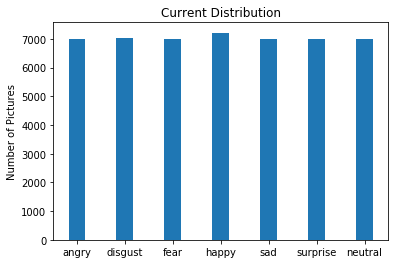

AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0]
Initialization complete. Distribution is:  [467  56 496 895 653 415 607]
Stage 2 begin. Target class size is: 800 Distribution multiplier is: [ 2. 15.  2.  1.  2.  2.  2.]


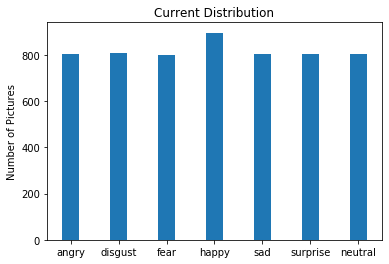

In [5]:
dataset_train = FERDataset(csv_file=csv_file, partition='Training', class_size=7000)
dataset_val = FERDataset(csv_file=csv_file, partition='PublicTest', class_size=800)

In [6]:
batch_size = 128
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=True)

tensor([[0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
        [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
        [0.6706, 0.6706, 0.6706,  ..., 0.6706, 0.6706, 0.6706],
        ...,
        [0.6588, 0.6627, 0.6549,  ..., 0.5725, 0.5451, 0.5294],
        [0.6588, 0.6627, 0.6510,  ..., 0.6118, 0.5961, 0.6157],
        [0.6588, 0.6549, 0.6510,  ..., 0.6039, 0.5922, 0.5765]],
       dtype=torch.float64)


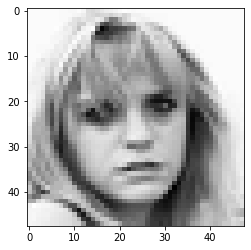

In [7]:
_, sample = next(enumerate(train_loader))
print(sample['image'][0])
plt.imshow(sample['image'][0], cmap='gray')

In [8]:
class EmoNet(nn.Module):
    def __init__(self):
        super(EmoNet, self).__init__()
        self.Res = resnet34
        self.Res.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.Res.fc = nn.Linear(512, 512)
        self.ReLU = nn.ReLU()
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 7)
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.Res(x)
        x = self.ReLU(x)
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.Softmax(x)
        return x

    def name(self):
        return "EmoNet"

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=[1,1], stride=1)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=[5,5], stride=1)
        self.activation2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size = [3, 3], stride=2, padding=0)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=[3,3], stride=1, padding=1)
        self.activation3 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size = [3, 3], stride=2, padding=0)
        
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=[5,5], stride=1, padding=2)
        self.activation4 = nn.ReLU()
        
        self.pool3 = nn.MaxPool2d(kernel_size = [3, 3], stride=2, padding=0)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 7)
        
        self.ReLU = nn.ReLU()
        self.Softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.activation1(x)
        
        x = self.conv2(x)
        x = self.activation2(x)
        
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.activation3(x)
        
        x = self.pool2(x)
        
        x = self.conv4(x)
        x = self.activation4(x)
        
        x = self.pool3(x)

        x = x.view(x.size()[0], -1)

        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.Softmax(x)
        
        return x

In [10]:
model = EmoNet()

In [36]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999))
# optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6, nesterov=True)
criterion = nn.CrossEntropyLoss()

In [22]:
model = model.cuda()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model.to(device)


for p in model.Res.conv1.parameters():
    p.requires_grad=True
for p in model.Res.layer1.parameters():
    p.requires_grad=True
for p in model.Res.layer2.parameters():
    p.requires_grad=True
for p in model.Res.layer3.parameters():
    p.requires_grad=True
for p in model.Res.layer4.parameters():
    p.requires_grad=True


True


In [24]:
training_stats = {}
training_stats['tarining_loss'] = []
training_stats['validation_loss'] = []
training_stats['accuracy'] = []

In [16]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

EmoNet(
  (Res): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
'''
writer = SummaryWriter('TensorBoard/EmoNet')

# get some random training images
dataiter = iter(train_loader)
sample = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(sample['image'])

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_images', img_grid)
'''

In [38]:
global epoch #declear epoch global, to be used later by torch.save() 

for epoch in range(1000):

    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 
    for batch_idx, diction in enumerate(train_loader):
        model.train() #set model to traning mode
        optimizer.zero_grad()
        x, target = diction['image'], diction['category'] #extract training data for this batch
        x = x.unsqueeze(1)
        x, target = x.float(), target.float() #set datatype
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target) #set to pytorch datatype: variable

        out = model(x) #forward pass

        loss = criterion(out, target.long()) #calculate loss
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 
        loss.backward() #back propagation with calculated loss
        optimizer.step() #calculate gradient and step
        
        if (batch_idx + 1) % 600 == 0 or (batch_idx + 1) == len(train_loader):
            print('>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))
        training_stats['tarining_loss'].append(loss)
            
        

    correct, ave_loss, total_cnt = 0, 0, 0
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        x, target = diction['image'], diction['category']
        x = x.unsqueeze(1)
        x, target = x.float(), target.float()
        x, target = x.to(device), target.to(device)
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target.long()) #calculate loss

        pred_label = out.data
        pred_label = pred_label.argmax(dim=1, keepdim=True)
        
        target = target.long()
        
        total_cnt += x.data.size()[0]
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 #smooth average
        correct += pred_label.eq(target.view_as(pred_label)).sum().item()
        
        if (batch_idx + 1) % 600 == 0 or (batch_idx + 1) == len(val_loader):
            print(
            '>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx + 1, ave_loss, correct * 1.0 / total_cnt))
            print('==================================================================') 
            
        training_stats['validation_loss'].append(ave_loss)
        training_stats['accuracy'].append(correct * 1.0 / total_cnt)


>>> epoch: 0, batch index: 385, train loss: 1.287593
>>> epoch: 0, batch index: 45, test loss: 1.614493, acc: 0.526
>>> epoch: 1, batch index: 385, train loss: 1.346610
>>> epoch: 1, batch index: 45, test loss: 1.619319, acc: 0.535
>>> epoch: 2, batch index: 385, train loss: 1.332668
>>> epoch: 2, batch index: 45, test loss: 1.600401, acc: 0.536
>>> epoch: 3, batch index: 385, train loss: 1.312084
>>> epoch: 3, batch index: 45, test loss: 1.624892, acc: 0.538
>>> epoch: 4, batch index: 385, train loss: 1.297834
>>> epoch: 4, batch index: 45, test loss: 1.620407, acc: 0.538
>>> epoch: 5, batch index: 385, train loss: 1.294113
>>> epoch: 5, batch index: 45, test loss: 1.621217, acc: 0.533
>>> epoch: 6, batch index: 385, train loss: 1.284656
>>> epoch: 6, batch index: 45, test loss: 1.616807, acc: 0.538
>>> epoch: 7, batch index: 385, train loss: 1.297356
>>> epoch: 7, batch index: 45, test loss: 1.597363, acc: 0.541
>>> epoch: 8, batch index: 385, train loss: 1.263856
>>> epoch: 8, batch

KeyboardInterrupt: 

In [40]:
from pthflops import count_ops

inp = torch.Tensor(np.zeros(57600).reshape(25, 1, 48, 48))

inp = inp.cuda()
inp = inp.to(device)

count_ops(model, inp)

Operation                   OPS         
--------------------------  ----------  
/onnx::Conv                 46080000    
/onnx::BatchNormalization   1843200     
/onnx::Relu                 1843200     
/onnx::MaxPool              1843200     
/onnx::Conv                 132710400   
/onnx::BatchNormalization   460800      
/onnx::Relu                 460800      
/onnx::Conv                 132710400   
/onnx::BatchNormalization   460800      
/onnx::Add                  230400      
/onnx::Relu                 460800      
/onnx::Conv                 132710400   
/onnx::BatchNormalization   460800      
/onnx::Relu                 460800      
/onnx::Conv                 132710400   
/onnx::BatchNormalization   460800      
/onnx::Add                  230400      
/onnx::Relu                 460800      
/onnx::Conv                 132710400   
/onnx::BatchNormalization   460800      
/onnx::Relu                 460800      
/onnx::Conv                 132710400   
/onnx::BatchNorm

(4720108800,
 [['/onnx::Conv', 46080000],
  ['/onnx::BatchNormalization', 1843200],
  ['/onnx::Relu', 1843200],
  ['/onnx::MaxPool', 1843200],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Add', 230400],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Add', 230400],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 460800],
  ['/onnx::Add', 230400],
  ['/onnx::Relu', 460800],
  ['/onnx::Conv', 66355200],
  ['/onnx::BatchNormalization', 230400],
  ['/onnx::Relu', 230400],
  ['/onnx::Conv', 132710400],
  ['/onnx::BatchNormalization', 230400],
  ['/onnx::Conv', 73728

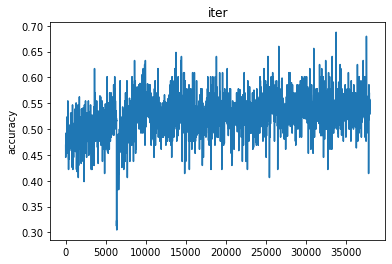

In [39]:
plt.figure()
'''
plt.subplot()
plt.plot(np.arange(len(training_stats['tarining_loss'])), training_stats['tarining_loss'])
plt.ylabel('training_loss')
plt.title('iter')

plt.subplot()
plt.plot(np.arange(len(training_stats['validation_loss'])), training_stats['validation_loss'])
plt.ylabel('validation_loss')
plt.title('iter')
'''
plt.subplot()
plt.plot(np.arange(len(training_stats['accuracy'])), training_stats['accuracy'])
plt.ylabel('accuracy')
plt.title('iter')

plt.show()

In [ ]:
print(np.max(training_stats['accuracy']))